In [11]:
import sys
sys.path.append('..')

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.models import common_neighbor_community as cnc
from src.features import max_intersect_accuracy as ac

r_seed = 123

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read dataset

Since the dataset is actually directed, we make it undirected to enable common neighbors methods.

In [12]:
G = nx.read_gml("../data/raw/polblogs.gml").to_undirected()
print("Number of nodes:", G.order())
print("Number of edges:", G.size())

Number of nodes: 1490
Number of edges: 16783


In [13]:
G.nodes["100monkeystyping.com"]

{'value': 0, 'source': 'Blogarama'}

In [14]:
actual_com = {}
for i in G.nodes:
    actual_com[i] = G.nodes[i]["value"]

actual_com["100monkeystyping.com"]


0

## Find the best threshold and test performance

Simply try a range of possible thresholds

In [15]:
def differentThes(lower_thres, higher_thres, interval, CNC):
    avg_accs = []
    ths = []
    max_thres = None
    max_acc = 0.0
    for thres in np.arange(lower_thres, higher_thres, interval):
        CNC.findAllCommunities(thres=thres, weighted=True)
        actual = CNC.getActualCommunities()
        pred = CNC.getPredCommunities()
        
        
        ths.append(thres)
        acc = ac.computeAccuracies(actual, pred)
        avg_accs.append(acc)
        
        if acc > max_acc:
            max_acc = acc
            max_thres = thres
    
    return pd.DataFrame({"accuracy": avg_accs, "threshold": ths}), max_acc, max_thres

def plotThresAcc(df):
    sns.lineplot(data=df, x="threshold", y="accuracy")
    plt.title("Accuracy per Threshold")
    plt.show()
    plt.close()

Specifically, attemp $0.01$ to $0.50$ which means $1\%$ to $50\%$ degrees are common neighbors determine two nodes are within a same community.

Max Accuracy: 0.43574549072191704
Max Threshold: 0.0


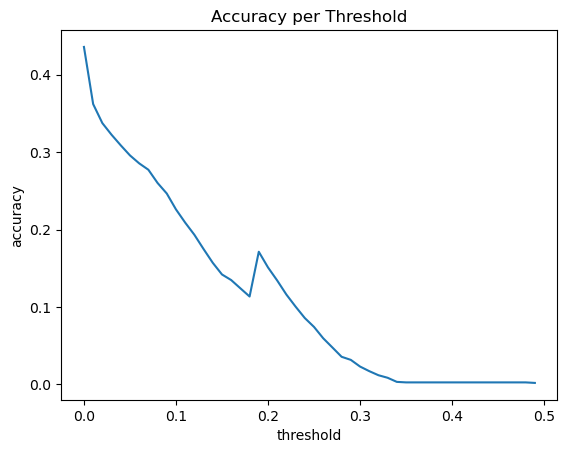

In [16]:
CNC = cnc.CommonNeighborCommunity(G, actual_com) # reset the graph
df, max_acc, max_thres = differentThes(0.00, 0.5, 0.01, CNC)

CNC.findAllCommunities(thres=max_thres, weighted=True)

print("Max Accuracy:", max_acc)
print("Max Threshold:", max_thres)
plotThresAcc(df)

As we can see the best average max intersected accuracy is $0.43$ which means this is under the baseline model for this dataset. More specifically, since this max accuracy occurs when the threshold is $0.0$ which means if there is any common neighbor between two nodes they are within the same community. However, this algorithm performs really bad in this dataset because the within community probability is quite low. In other words, for nodes within the same community, they are not likely to be connected with a common neighbor.

More specifically, we can see `notebookx/polblogs_stats.ipynb`. The in-group probability is $0.0315$ which is much lower than other networks we've tested, including $0.3$ for all random networks and $0.36$ for EU emails.